In [2]:
import numpy as np
from skimage import io, filters
from skimage.color import rgb2gray
from scipy.ndimage import convolve
import matplotlib.pyplot as plt

**1)  Convolution  and  filtering**

Find  an  image  and  make  it  grayscale  (2D)  if it isn’t already 
using whatever means you like. Also make an 11×11 square array  in which all the elements are the 
same. Perform a local averaging of the image by convolving it with the 11×11 array. In Python use 
convolve in the scipy.ndimage package. In MATLAB use imfilter; this is similar to conv2 but 
allows  clearer  statements  about  what  to  do  at  the  borders.  (There  are  other  subtle  differences 
between the two.) Try at least two different choices for what the convolution does near and beyond 
the image borders, one of which is zero-padding. Submit a “Zoomed in” image for each choice, and 
comment on whether they are doing what you expect.  
 
Suggestion: Pick an image that isn’t too large (maybe 600x600?), so that you can see the effects of the 
filtering more clearly. Or you can make a larger kernel – not 11×11, but something like 51×51, but 
be warned that this may be slow. 
Comment:  The  “Zoomed in” image should zoom in to the edge, of course, so you can see the 
difference between edge options. 
Comment: Recall that “zero padding” means filling all the “new” pixels beyond the edge with zeros. 

In [3]:
def showim(im_array, figsize = (11,5), show_hist = False):
    
    if show_hist:
        im_flattened = im_array.ravel()
        number_of_bins = (np.max(im_flattened) - np.min(im_flattened))
        
        plt.figure(figsize=figsize)
        plt.subplot(1,2,1)
        plt.imshow(im_array, cmap='gray')
        plt.axis('off')
        
        plt.subplot(1,2,2)
        plt.hist(im_flattened, bins=number_of_bins, color='black') 
        plt.xlabel('Intensity Value')
        plt.ylabel('Frequency')
        plt.title('Image Intensity Histogram')

        plt.tight_layout()

    else:
        plt.figure(figsize=figsize)
        plt.imshow(im_array, cmap='gray')
        plt.axis('off')

def thresh_otsu(im_array, show_results = False):

    if show_results:
        
        plt.figure(figsize=(15,7))

        otsu_thresh = filters.threshold_otsu(im_array)
        image_otsu_thresh = (im_array > otsu_thresh).astype(np.uint8)
        plt.subplot(1,2,1)
        plt.imshow(image_otsu_thresh, cmap='gray')
        plt.axis('off')

        im_array_flattened = im_array.ravel()

        plt.subplot(1,2,2)
        plt.hist(im_array_flattened, bins=256, color='black')
        plt.axvline(otsu_thresh, color='red', linestyle='dashed', linewidth=2)
        plt.title('Image Intensity Histogram')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')

    else:
        otsu_thresh = filters.threshold_otsu(im_array)
        image_otsu_thresh = (im_array > otsu_thresh).astype(np.uint8)

    return image_otsu_thresh

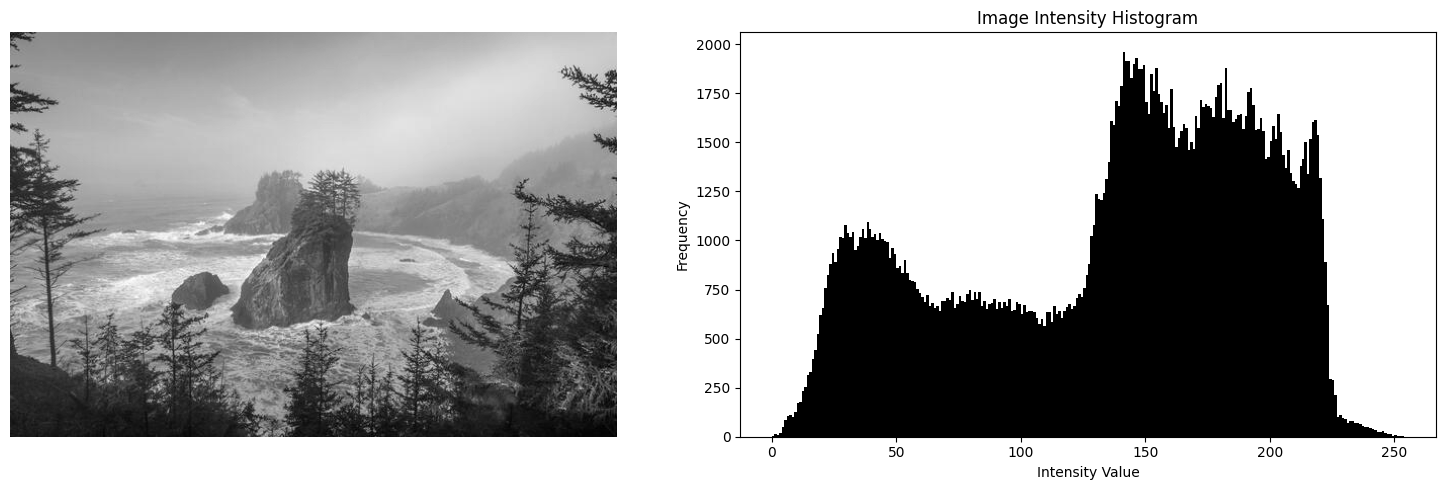

In [4]:
coast_image = (rgb2gray(io.imread('/home/apd/Projects/ImageAnalysis/HW3/Oregon-Coast-1694.jpg'))*255).astype(np.uint8)
showim(coast_image, figsize=(15,5),show_hist=True)

In [5]:
kernel_size = 11
square_kernel = np.ones((kernel_size, kernel_size)) / (kernel_size**2)

conv_zero_pad = convolve(coast_image, square_kernel, mode='constant', cval=0)  
conv_reflect = convolve(coast_image, square_kernel, mode='reflect')

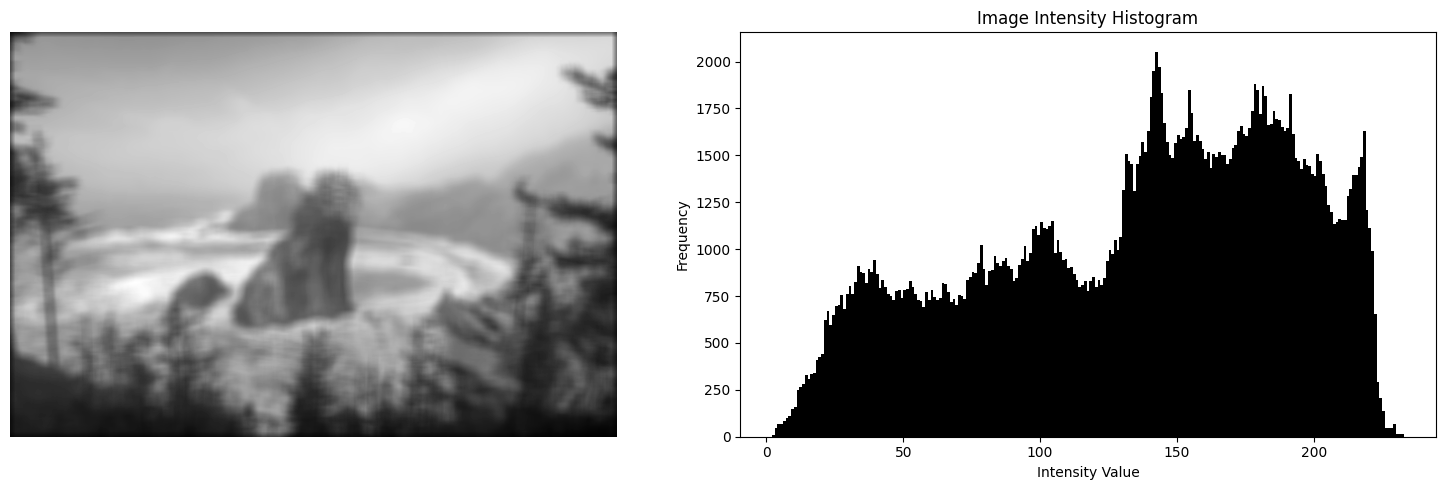

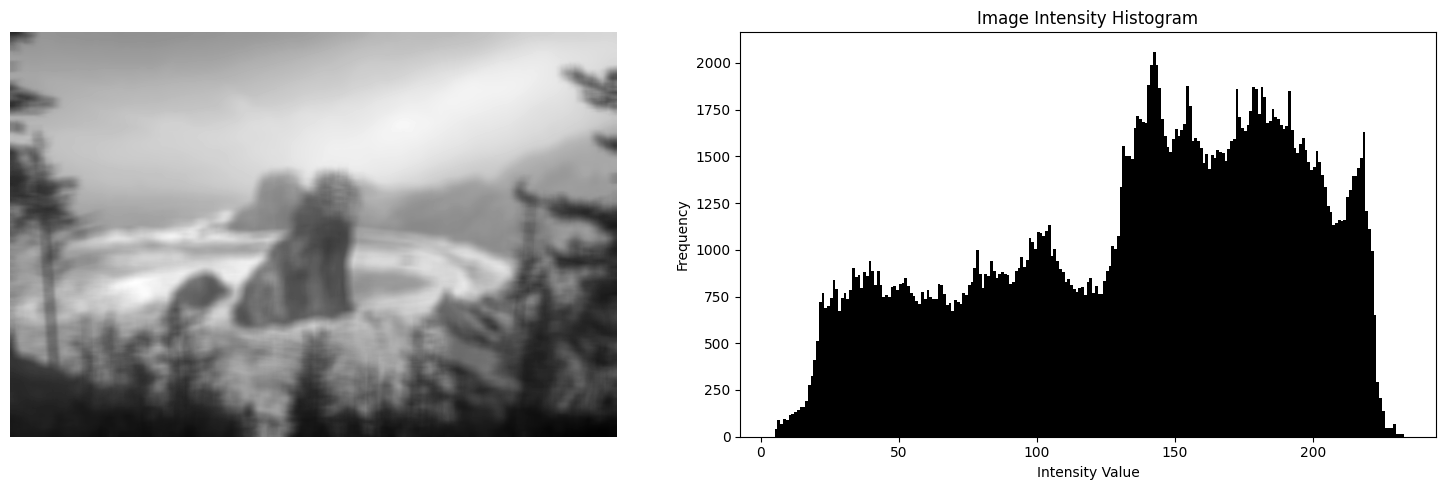

In [6]:
showim(conv_zero_pad, figsize=(15,5), show_hist=True)
showim(conv_reflect, figsize=(15,5), show_hist=True)

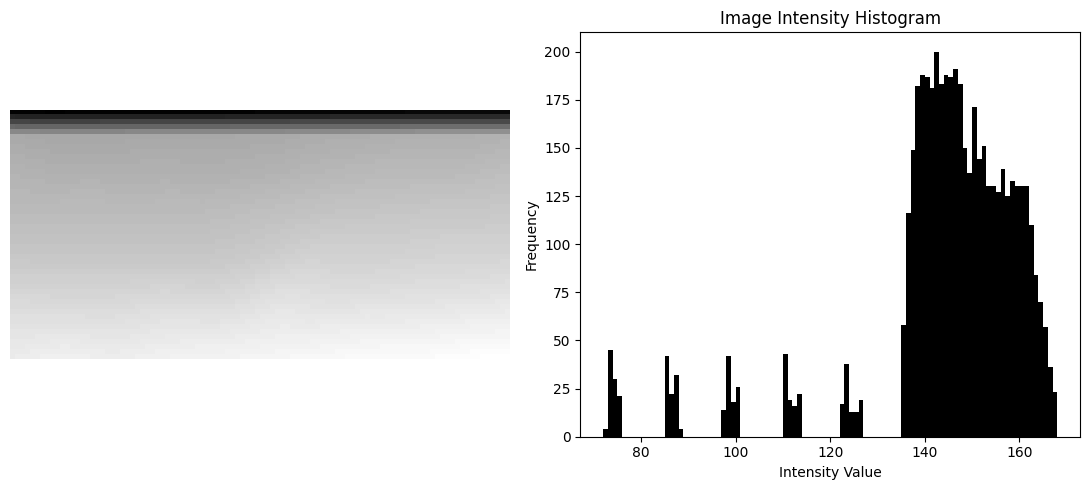

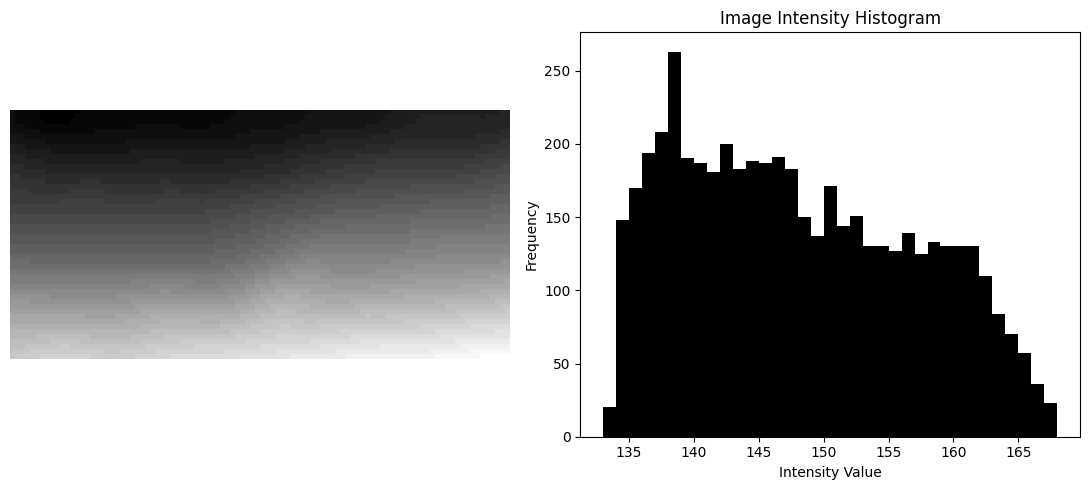

In [7]:
zoom_ROI_1 = (slice(0, 50), slice(100, 200))
zoom_1 = conv_zero_pad[zoom_ROI_1]
showim(zoom_1, show_hist=True)

zoom_ROI_2 = (slice(0, 50), slice(100, 200))
zoom_2 = conv_reflect[zoom_ROI_2]
showim(zoom_2, show_hist=True)

Both of these zooms are taken from the top left of the image, showing the top border. With zero padding, substitute values are just 0, which is apparent when looking at a histogram of the values near the border (we have discrete little peaks representing each horizontal bar as the kernel shifts upwards and more zeros need to be sibstituted in). The reflect seems to just reflect back the nearest pixel values, giving a much smoother distribution.

**2 Gaussian filtering** 

Find a grayscale image or make a color image grayscale however you 
like;  choose  an  image  that  has  some  fairly  sharp  edges.  We’ll  perform  Gaussian  filtering  of  this 
image. Note that a Gaussian function is 𝐴exp(− (𝑟^2) / 2(𝜎^2)) where r is the distance to the center.

**a)** Gaussian-filter  the  image  by  explicitly  creating  a  Gaussian  kernel  and  convolving  it 
with your image as in Problem 1. Show your code for making the kernel. (Hint: use meshgrid 
for x and y positions, then figure out “r ”.) Show the original image, an image of your kernel 
and the output of the convolution for two different values of the Gaussian width, σ. 


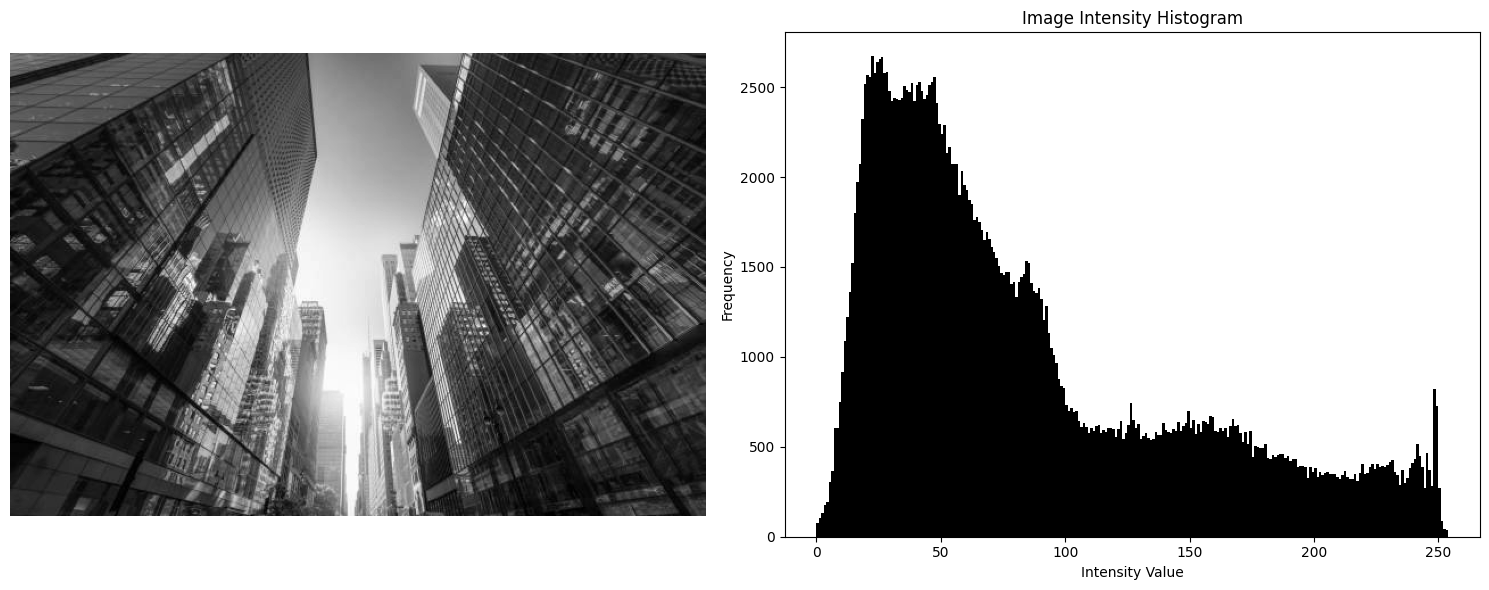

In [8]:
street_image = (rgb2gray(io.imread('/home/apd/Projects/ImageAnalysis/HW3/street2.jpg'))*255).astype(np.uint8)
showim(street_image, show_hist=True, figsize=(15,6))

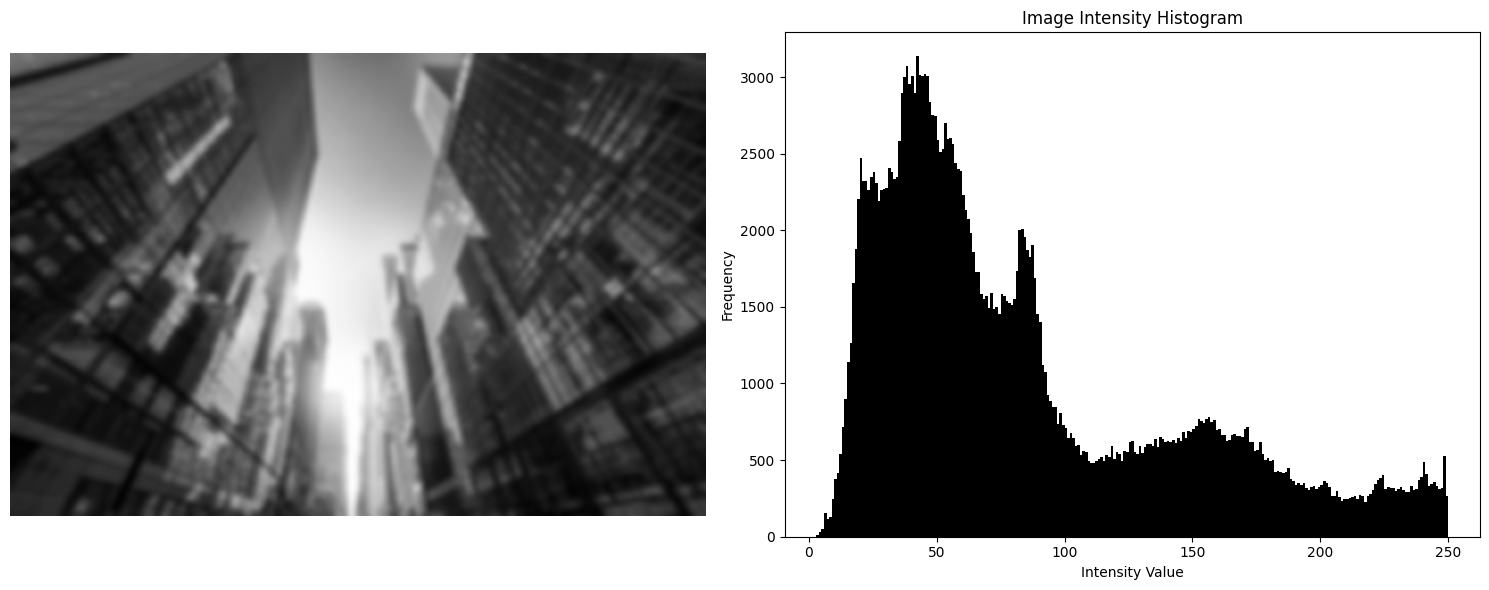

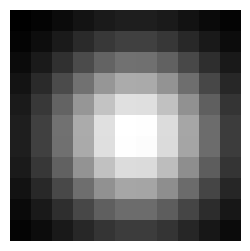

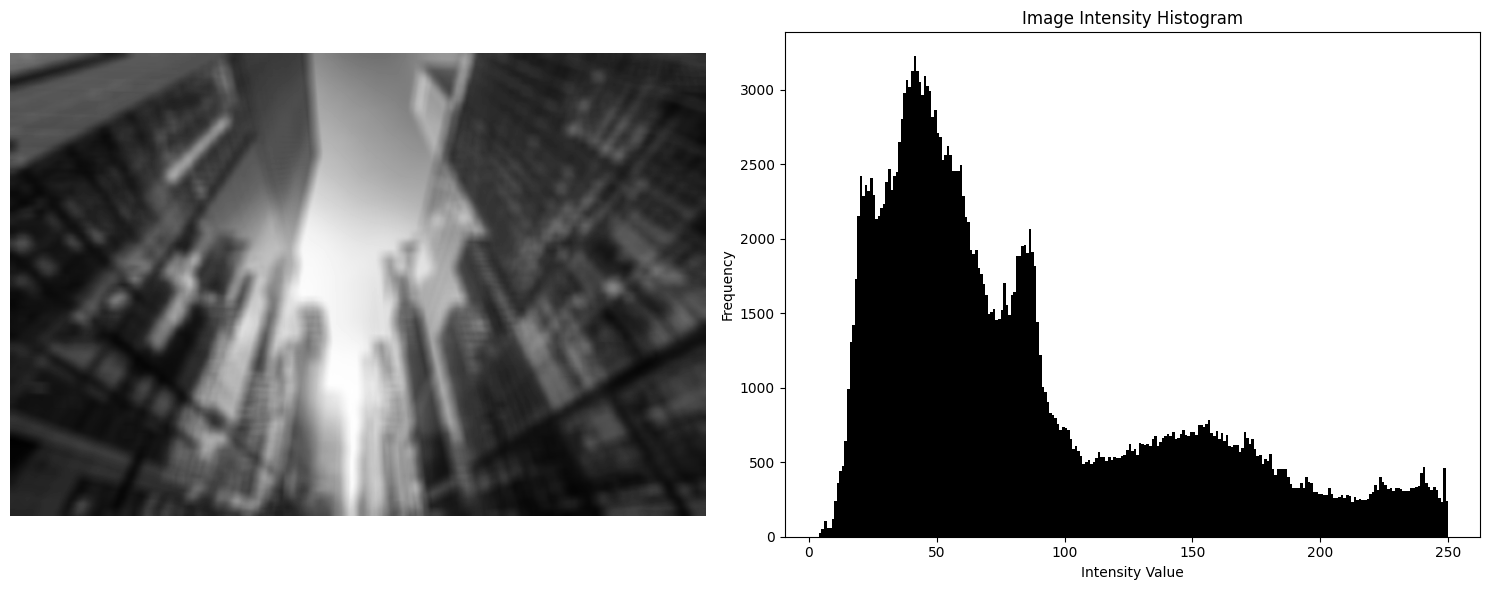

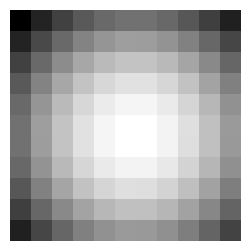

In [9]:
def create_gauss_kernel(kernel_size, sigma):
    
    length = np.linspace(-kernel_size//2, kernel_size//2, kernel_size)

    x, y = np.meshgrid(length, length)
    r = np.sqrt(x**2 + y**2)
    kernel = np.exp(-(r**2) / (2 * sigma**2))
    return kernel / kernel.sum() 

small_gauss_kernel = create_gauss_kernel(11,3)
street_conv_1 = convolve(street_image, small_gauss_kernel)
showim(street_conv_1, show_hist=True, figsize=(15,6))
showim(small_gauss_kernel, figsize=(3,3))

wider_gauss_kernel = create_gauss_kernel(11,9)
street_conv_2 = convolve(street_image, wider_gauss_kernel)
showim(street_conv_2, show_hist=True, figsize=(15,6))
showim(wider_gauss_kernel, figsize=(3,3))


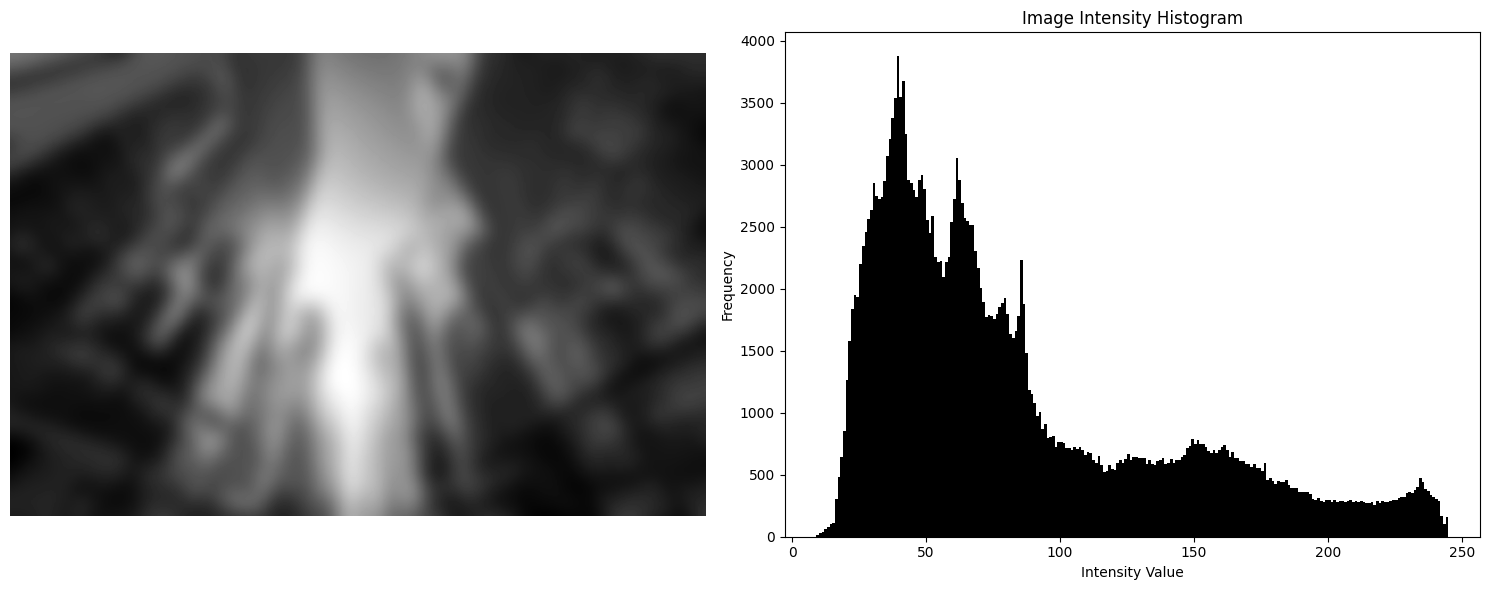

In [10]:
from skimage.filters import gaussian
new_gauss = (gaussian(street_image, sigma=9)*255).astype(np.uint8)
showim(new_gauss, show_hist=True, figsize=(15,6))

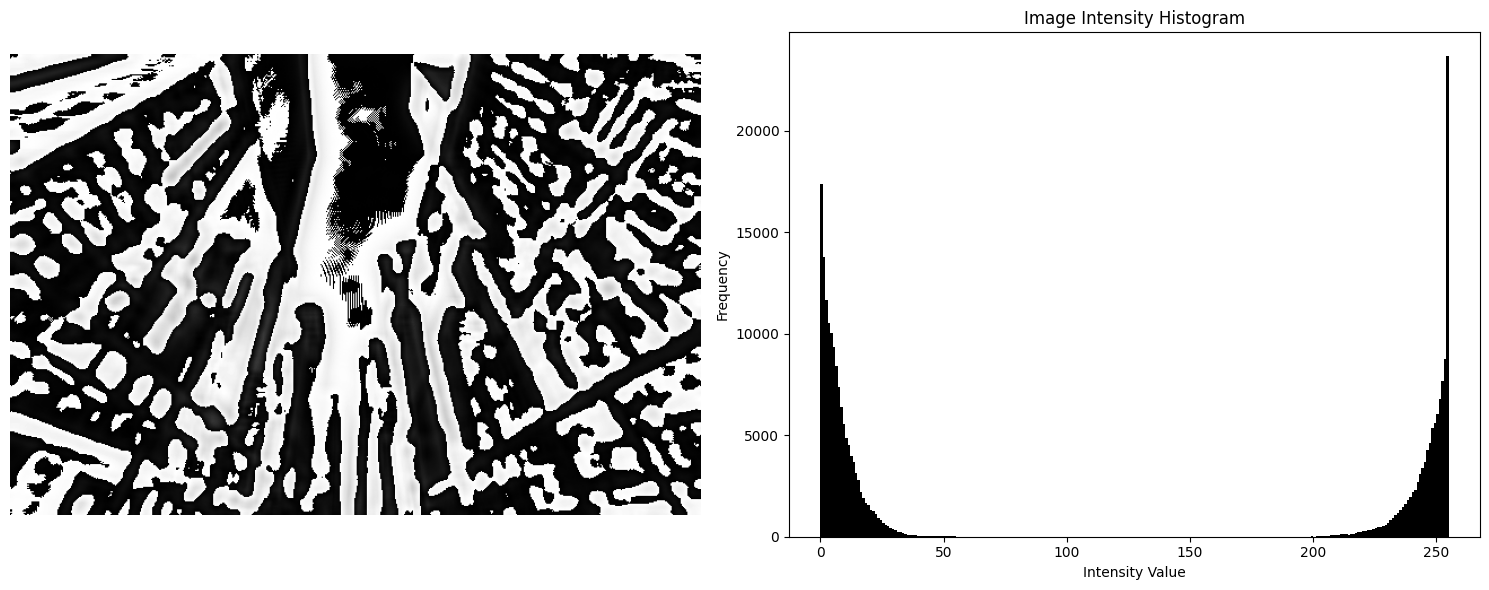

In [11]:
difference = new_gauss-street_conv_2
showim(difference, show_hist=True, figsize=(15,6))

It seems like the convolved images mainly differ around the edges of the buildings, or sharp edges. After doing some reading, it seems like skimage doesn't use an actual kernel thats an array but performs efficient mathematical operations on the image, meaning it likely doesn't have to "clip" its gaussian kernel like we do when we choose an explicit size (not sigma) for it. In that way, skimage's gaussian convolution is probably more mathematically accurate as it is able to incorporate more image information into it's calculations.

In [12]:
import time
manual_to = time.time()
manual_conv = convolve(street_image, wider_gauss_kernel)
manual_tf = time.time()

skimage_to = time.time()
skimage_conv = gaussian(street_image, sigma=9)
skimage_tf = time.time()

print(f"manual time: {manual_tf-manual_to}")
print(f"skimage time: {skimage_tf-skimage_to}")


manual time: 0.04272747039794922
skimage time: 0.01588153839111328


By decomposing a 2-D seperable kernel (matrix) into two 1-D kernels (rows), the results of the application of each of these 1-D kernels put together reconstructs the explicit application of the 2-D convolution with less computations. It scales much better with increasing kernel sizes! In the this problem, skimage likely uses this method to convolve the image, where my manual version is slower as it sticks to explicit computation off of a 2-D kernel. 

median time: 0.2213270664215088


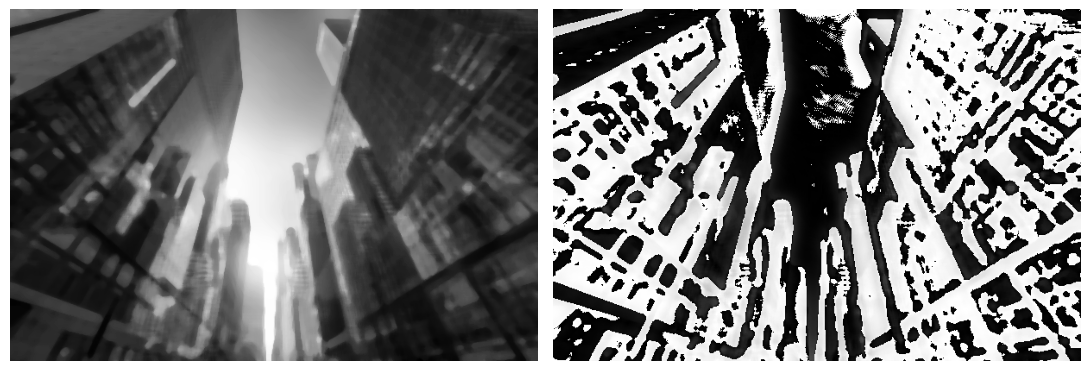

In [13]:
from skimage.filters import median

median_t0 = time.time()
median_conv = median(street_image, np.ones((9,9)))
median_tf = time.time()

difference = median_conv - new_gauss

print(f"median time: {median_tf-median_t0}")

plt.figure(figsize=(11,7))
plt.subplot(1,2,1)
plt.imshow(median_conv, cmap = 'gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(difference, cmap = 'gray')
plt.axis('off')
plt.tight_layout()


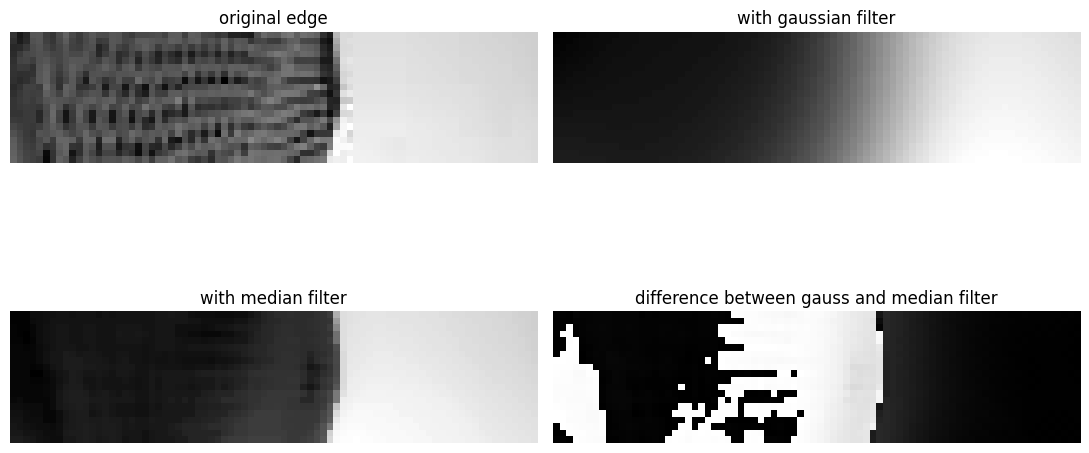

In [14]:
street_zoom = (slice(80, 100), slice(220, 300))

plt.figure(figsize=(11,7))

plt.subplot(2,2,1)
plt.imshow(street_image[street_zoom], cmap = 'gray')
plt.title('original edge')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(new_gauss[street_zoom], cmap = 'gray')
plt.title('with gaussian filter')
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(median_conv[street_zoom], cmap = 'gray')
plt.title('with median filter')
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(difference[street_zoom], cmap = 'gray')
plt.title('difference between gauss and median filter')
plt.axis('off')
plt.tight_layout()


Again the differences seem to be at the edges. The median filter seems to make either side of the edge more pronounced, it's either very dark or light on either side of the edge. The gaussian filter smooths the edge out, essentially blurring it. The median filter also takes much longer, about and order of magnitude for a kernel size of 11x11!

**4)  Filtering  and  thresholding** 

Apply  (separately)  a  Gaussian  and  a  median  filter  to  the 
photo  “MakeUp_RichardPrince_1983_gray.png”  (on  Canvas),  and  then  threshold  the  resulting 
images  using Otsu’s method.  Use  a  similar  median  filter  size  as  the  Gaussian  width.  Comment  on 
the appearance of the thresholded images.

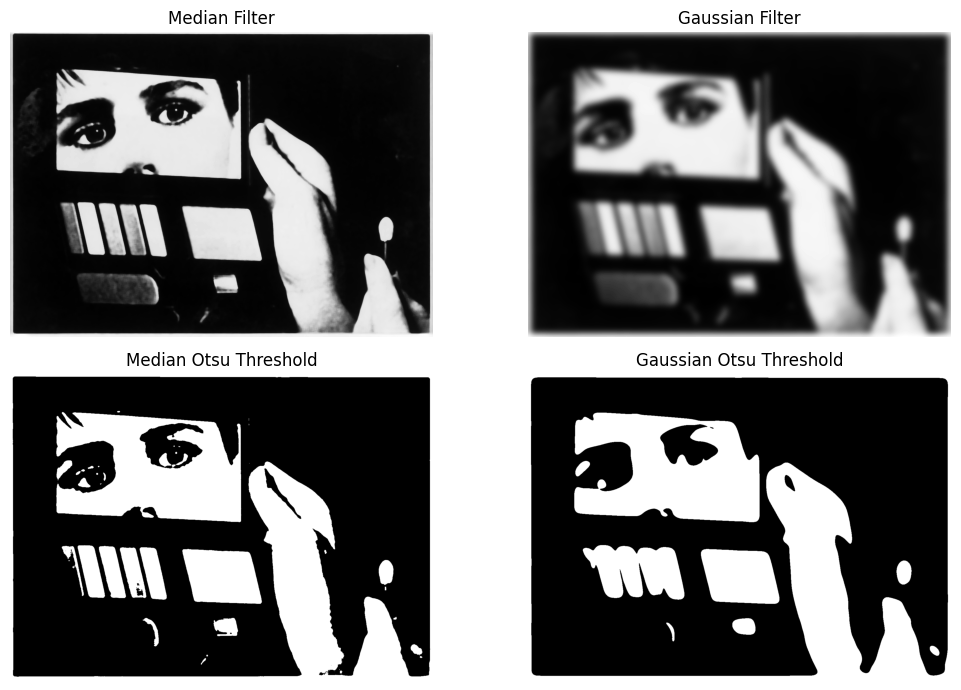

In [15]:
makeup_image = io.imread('/home/apd/Projects/ImageAnalysis/HW3/MakeUp_RichardPrince_1983_gray.png')

makeup_median = median(makeup_image, np.ones((11,11)))
makeup_gauss = gaussian(makeup_image, sigma = 11)

mm_thresh = thresh_otsu(makeup_median)
mg_thresh = thresh_otsu(makeup_gauss)

plt.figure(figsize=(11,7))

plt.subplot(2,2,1)
plt.imshow(makeup_median, cmap = 'gray')
plt.title('Median Filter')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(makeup_gauss, cmap = 'gray')
plt.title('Gaussian Filter')
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(mm_thresh, cmap = 'gray')
plt.title('Median Otsu Threshold')
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(mg_thresh, cmap = 'gray')
plt.title('Gaussian Otsu Threshold')
plt.axis('off')
plt.tight_layout()

The threshold on the median image seems more defined, while the threshold on the gaussian image seems to deliver a more smooth, abstract image (it almost looks like it just captures the photos). This lines up with the operations of each kernel, and results from the last problem.

**5)  High-pass  filtering** 

As noted in class, a Gaussian filter is a “low pass” filter, retaining 
gently-varying  (low  spatial  frequency)  changes  in  intensity  and  smoothing  close-together  changes 
(high spatial frequency). Any image is a combination of low- and high-frequency components. (We 
can be more exact about this using the Fourier analysis; we may revisit this later.) Therefore, if we 
subtract  a  Gaussian-filtered  image  from  the  original  image,  we’re  left  with  the  high-frequency 
components. This subtraction (the “identity filter” minus a Gaussian filter) is a high-pass  filter. 
Download  “Elevator_to_the_gallows.png”  and  create  a  high-pass-filtered  image  with  Gaussian 
width  21.  Submit  the  image  and  comment  on  its  appearance.  Note the intensity range: if you’re 
subtracting double-precision numbers, you may wish to set negative values equal to zero

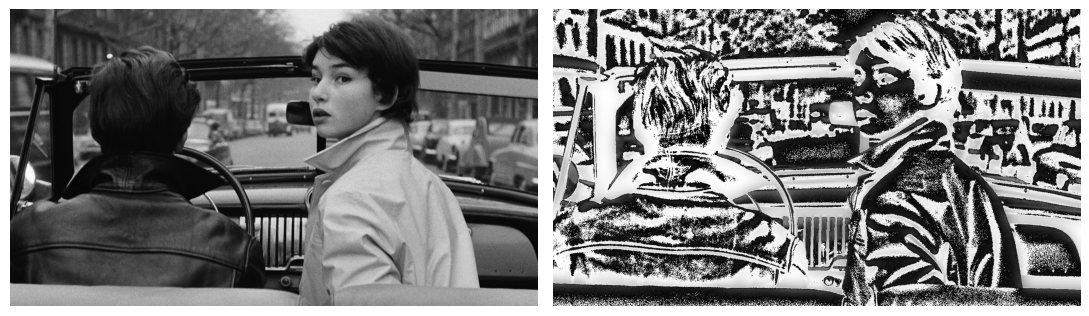

In [16]:
gallows_image = io.imread('/home/apd/Projects/ImageAnalysis/HW3/Elevator_to_the_gallows.png')
gallows_gaussian = (gaussian(gallows_image, sigma=21)*255).astype(np.uint8)
gallows_highpass = gallows_image-gallows_gaussian

plt.figure(figsize=(11,7))
plt.subplot(1,2,1)
plt.imshow(gallows_image, cmap = 'gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(gallows_highpass, cmap = 'gray')
plt.axis('off')
plt.tight_layout()


Areas where there isn't much variation, such as the road, areas of the jackets with the same shading, and the sky all don't "pass" through the filter, whereas finer and more varied sections such as hair, trees, and the complex shadows of the jackets, all pass through the filter. 

**6  Band-pass  filtering**   

We’ve now seen low-pass  and  high-pass  filtering.  We  can  combine 
these to make a band-pass filter which, as you might guess, keeps middle-frequency components of 
an  image. Load the image “gaussians_s2_to_s50_px.tif,” which is a grid of Gaussians with varying 
width, from about σ = 2 to 50 pixels. Figure out a series of low or high pass filtering and subtraction 
steps that will diminish the intensity of the “big” and the “small” dots, leaving the “medium” dots 
relatively  intact.  (“Relatively”  is  important:  you  won’t  perfectly  reject  or  keep  dots,  but  the  middle 
columns should be attenuated less than the outer ones.) Describe your procedure in words, include 
your code. Submit an image of the final band-pass filtered image. Also submit a plot of intensity vs. 
column number (i.e. “x”) for row 1240, as indicated below, including both the original and the band-
pass-filtered images

In [31]:
print(np.max(garray_lowpass))

255


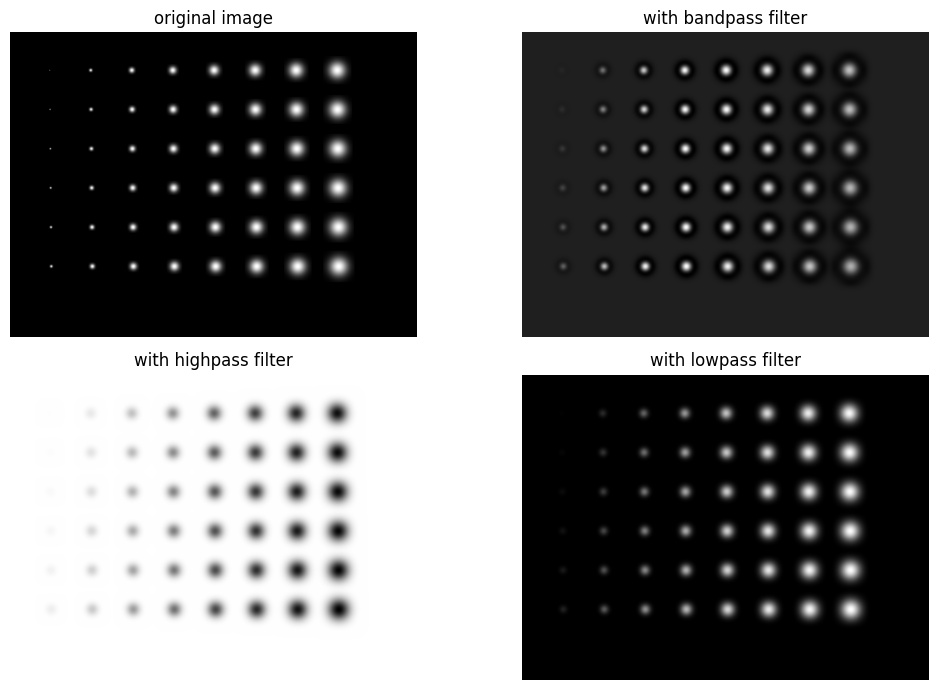

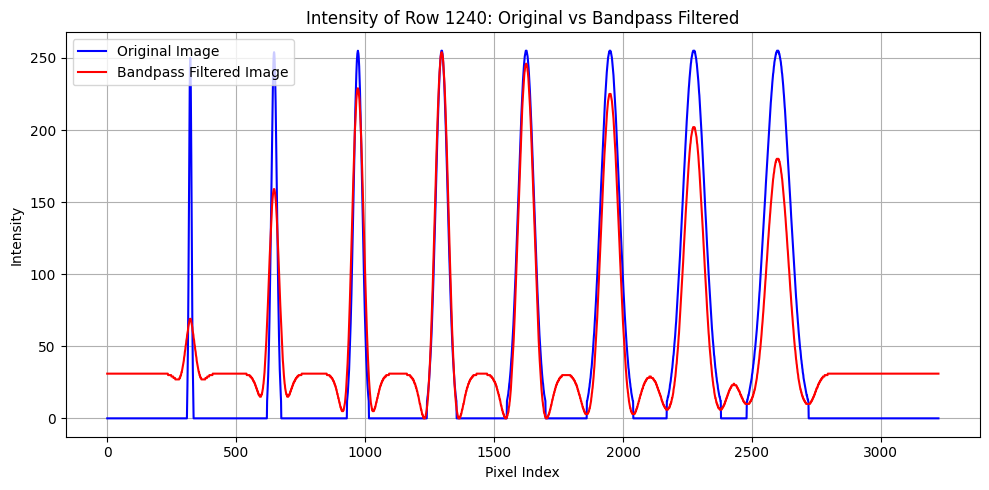

In [74]:
def normalize_uint8(array):
    # Shift the array so that the minimum value is 0
    array = array +  abs(np.min(array))
    # Normalize to the 0-255 range
    array = (array / np.max(array)) * 255
    return array.astype(np.uint8)

def invert_array(arr):
    return 255 - arr

# Load and convert image to float32
garray = io.imread('/home/apd/Projects/ImageAnalysis/HW3/gaussians_s2_to_s50_px.tif').astype(np.float32)

# Apply Gaussian filters
highpass = (gaussian(garray, sigma=30) * 255).astype(np.float32)
lowpass = (gaussian(garray, sigma=20) * 255).astype(np.float32)

garray_highpass = normalize_uint8((garray - highpass))
garray_lowpass = normalize_uint8((garray + lowpass))
garray_bandpass = normalize_uint8(garray - highpass + lowpass)


plt.figure(figsize=(11,7))

plt.subplot(2,2,1)
plt.imshow(garray, cmap = 'gray')
plt.title('original image')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(garray_bandpass, cmap = 'gray')
plt.title('with bandpass filter')
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(garray_highpass, cmap = 'gray')
plt.title('with highpass filter')
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(garray_lowpass, cmap = 'gray')
plt.title('with lowpass filter')
plt.axis('off')
plt.tight_layout()

row_original = garray[1240, :]
row_bandpass = garray_bandpass[1240, :]

# Plot the intensity values
plt.figure(figsize=(10,5))

plt.plot(row_original, label='Original Image', color='blue')
plt.plot(row_bandpass, label='Bandpass Filtered Image', color='red')

plt.title('Intensity of Row 1240: Original vs Bandpass Filtered')
plt.xlabel('Pixel Index')
plt.ylabel('Intensity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Since a gaussian convolution acts as a lowpass filter, if we subtract it from the original image we get a highpass filter as a result. Thus, I subtracted a higher larger kernel size convolution from the image (what I'm calling highpass) while also adding a smaller kernel size convolution kernel (what I'm calling lowpass) to the image to effectively pass it through both a low and high pass filter. Looking at the peaks in the plot above, we can see it works somewhat, although I'm still having trouble with filtering out some of the right-most peaks.